In [1]:
import random
import os
import time
import gc
from statistics import mean
import itertools

import pandas as pd
from pandas import read_csv
import numpy as np
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.ioff()
%matplotlib inline

from utils import get_dataset_parameterized

In [2]:
device = int(input("Select one of the following: \n1. Plug \n2. Bulb \n3. Cam"))
if not device in [1, 2, 3]:
    raise ValueError("'device' parameter must be one of the following values: 1, 2 or 3. 1 represents plugs, 2 represents light bulbs and 3 represents cameras.")
if device == 1:
    device_selection = "plug"
elif device == 2:
    device_selection = "light"
else:
    device_selection = "cam"

noise_type = int(input("Select one of the following: \n1. Random \n 2. IOT \n3. Network \n, 4. None \n"))
if not noise_type in [1, 2, 3]:
    raise ValueError("'noise_type' selection must be one of the following values: 1, 2 or 3.")

csv_output_name = f"flexhash_auto_parameter_select_{device_selection}.csv"
performance_visualization_df = pd.DataFrame(columns=["dataset name", "C_UC", "accum", "window", "combo", "acc", "bal_acc", "f1"])

c_uc_params = list(itertools.repeat(1, 48)) + list(itertools.repeat(2, 48))
noise_params = list(itertools.repeat(1, 96))
if device_selection == "plug":
    device_params = list(itertools.repeat(1, 96))
elif device_selection == "light":
    device_params = list(itertools.repeat(2, 96))
else:
    device_params = list(itertools.repeat(3, 96))
i_ni_params = list(itertools.repeat(1, 96))
accum_params = list(itertools.repeat(128, 12)) + list(itertools.repeat(256, 12)) + list(itertools.repeat(512, 12)) + list(itertools.repeat(1024, 12)) + list(itertools.repeat(128, 12)) + list(itertools.repeat(256, 12)) + list(itertools.repeat(512, 12)) + list(itertools.repeat(1024, 12))
window_params = (list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)) +
                 list(itertools.repeat(4, 3)) + list(itertools.repeat(5, 4)) + list(itertools.repeat(6, 5)))
combo_params = [
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
    2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 6,
]

dataset_params = zip(experiment_type_params, c_uc_params, noise_params, device_params, i_ni_params, accum_params, window_params, combo_params)

In [ ]:
max_average_accuracy = 0
max_average_accuracy_accum = -1
max_average_accuracy_window = -1
max_average_accuracy_combo = -1

for experiment_type, c_uc, noise, device, i_ni, accum, window, combo in dataset_params:
    dataset, name_of_current_data = get_dataset_parameterized(experiment_type, c_uc, noise, device, i_ni, accum, window, combo)

    # x is the entire dataframe except for the class column
    x = dataset.drop(['class'], axis=1)
    # y_original is an unaltered list of all values in the class column
    y_original = dataset['class'].values.tolist()
    # y is a dataframe of only the class column and the values have been converted to numeric representation
    y = dataset['class']
    counter = 0
    y_temp = dataset['class'].tolist()
    for unique_value in sorted(y.unique()):
        for index, value in enumerate(y):
            if value == unique_value:
                y_temp[index] = counter
        counter += 1
    dataset["class"] = y_temp
    y = dataset['class']
    _, x_test, _, _ = train_test_split(x.values, y.values, test_size=.2, stratify=y.values)

    del dataset, y_original, y_temp, x, y
    collected = gc.collect()

    temp_model = ensemble.HistGradientBoostingClassifier()
    cross_val_results = cross_validate(temp_model, x.values, y.values, cv=7,
                                       scoring=['accuracy'], n_jobs=7)
    temp_average_accuracy = mean(cross_val_results['test_accuracy'])


count = 0
for experiment_type, c_uc, noise, device, i_ni, accum, window, combo in dataset_params:
    count += 1
    print(f"{count}. {experiment_type}, {c_uc}, {noise}, {device}, {i_ni}, {accum}, {window}, {combo}")

    dataset, name_of_current_data = get_dataset_parameterized(experiment_type, c_uc, noise, device, i_ni, accum, window, combo)

    print(f"Dataset Name: {name_of_current_data}")

    # print(f"*** Total samples in {name_of_current_data}: {len(dataset.index)} ***")
    # for device_name in dataset["class"].unique():
    #     num_samples = len((dataset[dataset["class"] == device_name]).index)
    #     print(f"*** Samples for device: {device_name} in {name_of_current_data}: {num_samples} ({num_samples/dataset.shape[0]}%) ***")

    # x is the entire dataframe except for the class column
    x = dataset.drop(['class'], axis=1)

    # y_original is an unaltered list of all values in the class column
    y_original = dataset['class'].values.tolist()

    # y is a dataframe of only the class column and the values have been converted to numeric representation
    y = dataset['class']
    counter = 0
    y_temp = dataset['class'].tolist()
    for unique_value in sorted(y.unique()):
        for index, value in enumerate(y):
            if value == unique_value:
                y_temp[index] = counter
        counter += 1
    dataset["class"] = y_temp
    y = dataset['class']
    labels_numeric = dataset['class'].unique()

    del dataset
    del y_original
    del y_temp
    del labels_numeric
    collected = gc.collect()

    print("*** Dataset Loaded ***")

    models = []
    models.append((1, ensemble.HistGradientBoostingClassifier()))

    # evaluate each model
    for model_name, model in models:
        # print(f"*** Begin Training and Evaluating {model_name} ***")
        start_time = time.time()

        # ******************** #
        # Cross Validation
        # ******************** #
        cv_num = 7
        if experiment_type == 1:
            cross_val_results = cross_validate(model, x.values, y.values, cv=cv_num,
                                               scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=1)
        else:
            cross_val_results = cross_validate(model, x.values, y.values, cv=cv_num,
                                               scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=7)
        # print(f"*** Finished Training and Evaluating {model_name} ***")
        # print(f"Dataset Name: {name_of_current_data}")
        # print(f"Runtime: {time.time() - start_time}")
        print(f"Accuracy: {round(mean(cross_val_results['test_accuracy']), 4)}")
        print(f"Balanced Accuracy: {round(mean(cross_val_results['test_balanced_accuracy']), 4)}")
        # print(f"F1: {mean(cross_val_results['test_f1'])}")
        print(f"Weighted F1: {round(mean(cross_val_results['test_f1_weighted']), 4)}")

        if experiment_type == 1 or experiment_type == 2:
            performance_visualization_df.loc[count] = [name_of_current_data, int(c_uc==1), noise, round(mean(cross_val_results['test_accuracy']), 4), round(mean(cross_val_results['test_balanced_accuracy']), 4), round(mean(cross_val_results['test_f1_weighted']), 4)]
        elif experiment_type == 3:
            performance_visualization_df.loc[count] = [name_of_current_data, int(c_uc==1), device, i_ni, round(mean(cross_val_results['test_accuracy']), 4), round(mean(cross_val_results['test_balanced_accuracy']), 4), round(mean(cross_val_results['test_f1_weighted']), 4)]
        else:
            performance_visualization_df.loc[count] = [name_of_current_data, int(c_uc==1), accum, window, combo, round(mean(cross_val_results['test_accuracy']), 4), round(mean(cross_val_results['test_balanced_accuracy']), 4), round(mean(cross_val_results['test_f1_weighted']), 4)]

    print()
    print("____________________")
    print()

performance_visualization_df.to_csv(f"../results/{csv_output_name}", index=False)

1. 1, 1, 1, -1, -1, -1, -1, -1


Generating random noise: 100%|██████████| 1558598/1558598 [00:15<00:00, 98887.01it/s] 


Dataset Name: cleaned_devices-random
*** Dataset Loaded ***


In [ ]:
# performance_visualization_df.to_csv("../figures/performance/{device_selection}.csv", index=False)

/tmp/ipykernel_11824/4145303268.py:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)
/tmp/ipykernel_11824/4145303268.py:77: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)
/tmp/ipykernel_11824/4145303268.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colo

<Figure size 640x480 with 0 Axes>

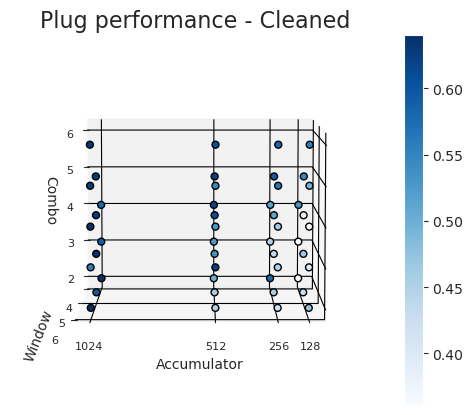

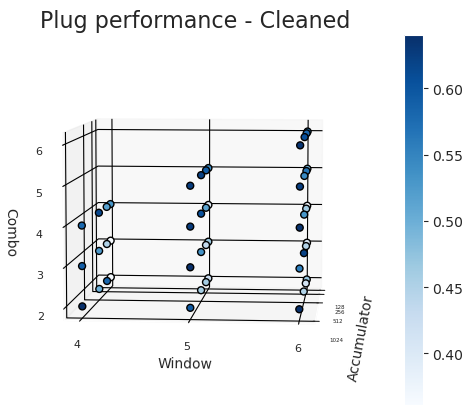

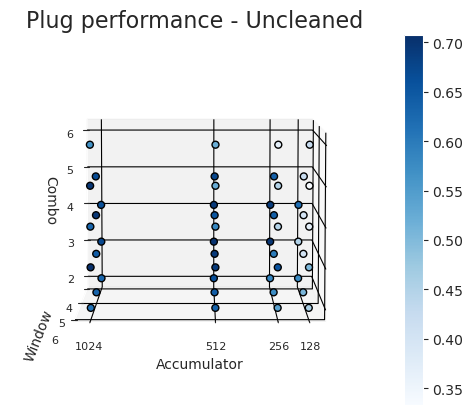

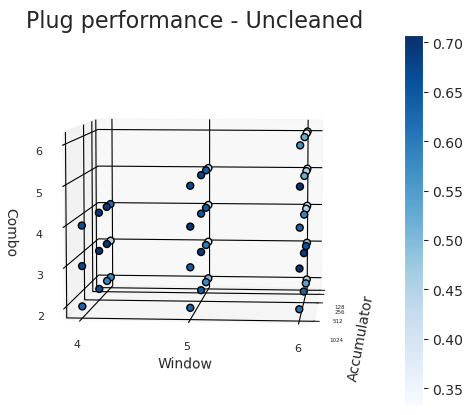

In [17]:
import random
import os
import time
import gc
from statistics import mean
import itertools

import pandas as pd
from pandas import read_csv
import numpy as np
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate

import seaborn as sns
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
# plt.ioff()
%matplotlib inline

device = int(input("Select one of the following: \n1. Plug \n2. Bulb \n3. Cam"))
if not device in [1, 2, 3]:
    raise ValueError("'device' parameter must be one of the following values: 1, 2 or 3. 1 represents plugs, 2 "
                     "represents light bulbs and 3 represents cameras.")
if device == 1:
    device_selection = "plug"
elif device == 2:
    device_selection = "light"
else:
    device_selection = "cam"
csv_output_name = f"flexhash_identical-devices_{device_selection}.csv"
performance_visualization_df = pd.read_csv(f"../results/{csv_output_name}", header=0)
plt.set_cmap("tableau-colorblind10")
plt.rcParams["grid.color"] = (0, 0, 0, 1)

performance_visualization_df_cleaned = performance_visualization_df[performance_visualization_df["C_UC"]==1.0]
cmap = matplotlib.colormaps["Blues"]
norm = matplotlib.colors.Normalize(vmin=performance_visualization_df_cleaned["bal_acc"].min(), vmax=performance_visualization_df_cleaned["bal_acc"].max())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(6, 90)
ax.set_facecolor("white")
ax.scatter(performance_visualization_df_cleaned["accum"].values,
           performance_visualization_df_cleaned["window"].values,
           performance_visualization_df_cleaned["combo"].values,
           marker="o", c=performance_visualization_df_cleaned["bal_acc"].values, s=25, edgecolor="black", depthshade=False, alpha=1)
ax.set_xlabel("Accumulator")
ax.set_ylabel("Window")
ax.set_zlabel("Combo")
ax.set_xticks([128, 256, 512, 1024])
ax.set_yticks([4, 5, 6])
ax.set_zticks([2, 3, 4, 5, 6])
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm)
title_string = f"{device_selection} performance - Cleaned"
plt.title(title_string[0].upper()+title_string[1:], fontsize=16)
plt.savefig(f"../figures/performance/{device_selection}_Cleaned_accumView.png", dpi=1200)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(6, 5)
ax.set_facecolor("white")
ax.scatter(performance_visualization_df_cleaned["accum"].values,
           performance_visualization_df_cleaned["window"].values,
           performance_visualization_df_cleaned["combo"].values,
           marker="o", c=performance_visualization_df_cleaned["bal_acc"].values, s=25, edgecolor="black", depthshade=False, alpha=1)
ax.set_xlabel("Accumulator")
ax.set_ylabel("Window")
ax.set_zlabel("Combo")
ax.set_xticks([128, 256, 512, 1024])
ax.set_yticks([4, 5, 6])
ax.set_zticks([2, 3, 4, 5, 6])
ax.tick_params(axis='x', labelsize=4)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm)
title_string = f"{device_selection} performance - Cleaned"
plt.title(title_string[0].upper()+title_string[1:], fontsize=16)
plt.savefig(f"../figures/performance/{device_selection}_cleaned_windowView.png", dpi=1200)

plt.rcParams["grid.color"] = (0, 0, 0, 1)

performance_visualization_df_uncleaned = performance_visualization_df[performance_visualization_df["C_UC"]==0.0]
cmap = matplotlib.colormaps["Blues"]
norm = matplotlib.colors.Normalize(vmin=performance_visualization_df_uncleaned["bal_acc"].min(), vmax=performance_visualization_df_uncleaned["bal_acc"].max())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(6, 90)
ax.set_facecolor("white")
ax.scatter(performance_visualization_df_uncleaned["accum"].values,
           performance_visualization_df_uncleaned["window"].values,
           performance_visualization_df_uncleaned["combo"].values,
           marker="o", c=performance_visualization_df_uncleaned["bal_acc"].values, s=25, edgecolor="black", depthshade=False, alpha=1)
ax.set_xlabel("Accumulator")
ax.set_ylabel("Window")
ax.set_zlabel("Combo")
ax.set_xticks([128, 256, 512, 1024])
ax.set_yticks([4, 5, 6])
ax.set_zticks([2, 3, 4, 5, 6])
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm)
title_string = f"{device_selection} performance - Uncleaned"
plt.title(title_string[0].upper()+title_string[1:], fontsize=16)
plt.savefig(f"../figures/performance/{device_selection}_uncleaned_accumView.png", dpi=1200)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(6, 5)
ax.set_facecolor("white")
ax.scatter(performance_visualization_df_uncleaned["accum"].values,
           performance_visualization_df_uncleaned["window"].values,
           performance_visualization_df_uncleaned["combo"].values,
           marker="o", c=performance_visualization_df_uncleaned["bal_acc"].values, s=25, edgecolor="black", depthshade=False, alpha=1)
ax.set_xlabel("Accumulator")
ax.set_ylabel("Window")
ax.set_zlabel("Combo")
ax.set_xticks([128, 256, 512, 1024])
ax.set_yticks([4, 5, 6])
ax.set_zticks([2, 3, 4, 5, 6])
ax.tick_params(axis='x', labelsize=4)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm)
title_string = f"{device_selection} performance - Uncleaned"
plt.title(title_string[0].upper()+title_string[1:], fontsize=16)
plt.savefig(f"../figures/performance/{device_selection}_uncleaned_windowView.png", dpi=1200)